In [1]:
import numpy as np
from ctypes import *
import matplotlib.pyplot as plt

from optic.dsp.core import upsample, pnorm, pulseShape, firFilter
from optic.comm.modulation import modulateGray, GrayMapping
from optic.plot import eyediagram

# Define uma classe que herda Structure para representação de números complexos.
class Complex(Structure):
    _fields_ = [("real", c_float),
                ("imaginary", c_float)]
    
# define o tipo "np.complex64" para matrizes numpy como parâmetro de entrada
npArrayTypeComplex = np.ctypeslib.ndpointer(dtype=np.complex64, flags="C_CONTIGUOUS")

def tuple2numpy(arr):
    """ 
    Converte um determinada tuple em um array
    numpy, (real, imag) --> np.array
    Args:
        arr (tuple): tuple contendo valores reais e imaginários
    Returns:
        np.array: array numpy de tipo complexo.
    """
    return np.array([complex(x[0], x[1]) for x in arr], dtype=np.complex64)

def c2py(arr, shape):
    """_summary_
    Args:
        arr (class '__main__.LP_Complex'): matriz de conversão para numpy
        shape (int): comprimento do array para 1D
    Returns:
        arr (np.array): matriz do tipo numpy unidimensional.
    """
    arr = np.ctypeslib.as_array(arr, shape=(shape,))
    return tuple2numpy(arr)

### Define as funções do DSP

In [2]:
outFile = "/home/silas/Documents/GitHub/TDI/src/dsp.so"
dsp = CDLL(outFile)

# bits
dsp.getRandomBits.argtypes = [c_int]
dsp.getRandomBits.restype  = POINTER(c_int)

# normalização
dsp.pnorm.restype  = POINTER(Complex)            
dsp.pnorm.argtypes = [npArrayTypeComplex, c_int]

# filtro FIR
dsp.firFilter.restype  = POINTER(Complex)
dsp.firFilter.argtypes = [npArrayTypeComplex, npArrayTypeComplex, c_int, c_int]

# decimação
dsp.downsample.restype  = POINTER(Complex)
dsp.downsample.argtypes = [npArrayTypeComplex, c_int, c_int]

# upsampling
dsp.upsample.restype  = POINTER(Complex)
dsp.upsample.argtypes = [npArrayTypeComplex, c_int, c_int]

# mainUP
dsp.mainUpSymbols.restype  = POINTER(Complex)
dsp.mainUpSymbols.argtypes = [c_int, c_int]

# filtro casado
dsp.matchedFilter.restype  = POINTER(Complex)
dsp.matchedFilter.argtypes = [npArrayTypeComplex, npArrayTypeComplex, c_int, c_int]

# formatação de pulso
dsp.pulseShape.restype  = POINTER(Complex)
dsp.pulseShape.argtypes = [c_int, c_int, c_float, c_float]


### Teste para geração de bits de forma pseudo-aleatória

(400000,)

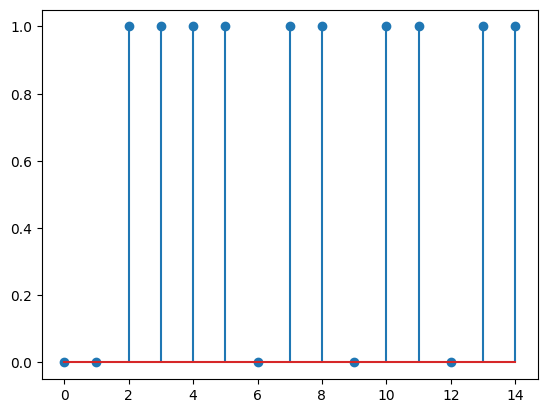

In [3]:
M = 16
Nbits = int(1e5*np.log2(M))

bits = dsp.getRandomBits(Nbits, M)
# converte o apontador de bits para um array numpy
bitsTx = np.ctypeslib.as_array(bits, shape=(Nbits,))

# imprime as primeiras 10 amostras de Nbits
plt.stem(bitsTx[0:15]);
bitsTx.shape

### Teste para normalização

In [4]:
nums = np.array([1.0 + 2.0j, 3.0 + 4.0j, 9.0 + 10.0j], dtype=np.complex64)

result_ptr = dsp.pnorm(nums, nums.size)
result_ptr = c2py(result_ptr, nums.size)

# compare o resultado
print(f"C: {result_ptr} \nOptiCommPy: {pnorm(nums)}")

C: [0.11923929+0.23847859j 0.35771787+0.47695717j 1.0731536 +1.192393j  ] 
OptiCommPy: [0.1192393 +0.23847859j 0.35771789+0.47695718j 1.07315366+1.19239295j]


### Downsampling 

/home/silas/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/silas/miniconda3/lib/python3.11/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/silas/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


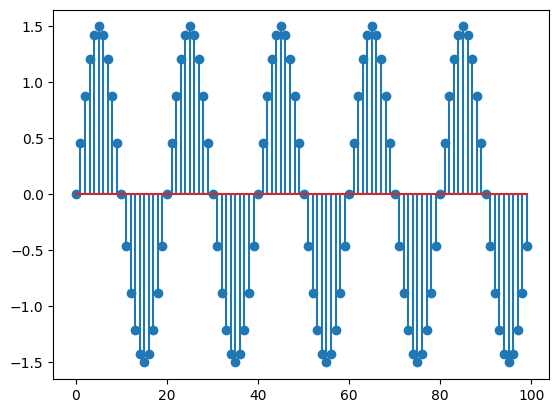

In [5]:
t = np.linspace(0, 1, 100, endpoint=False)
# Gerando o sinal discreto (no caso, um sinal senoidal)
signal = 1.5 * np.sin(2 * np.pi * 5 * t)
signal = np.array(signal, dtype=np.complex64)

plt.stem(signal);

(33,)

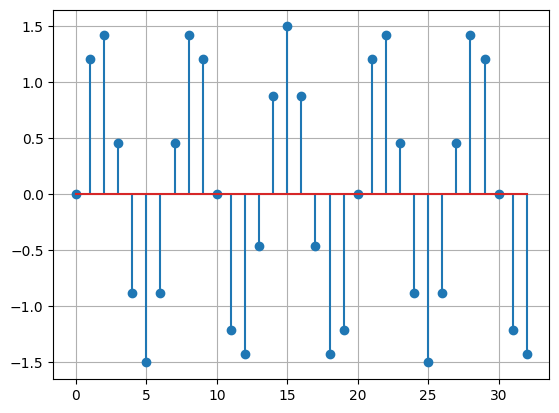

In [6]:
discard = 3
sigDecimate = dsp.downsample(signal, signal.size, discard)
sigDecimate = c2py(sigDecimate, int(signal.size/discard))

plt.stem(sigDecimate)
plt.grid();
sigDecimate.shape

### Upsampling

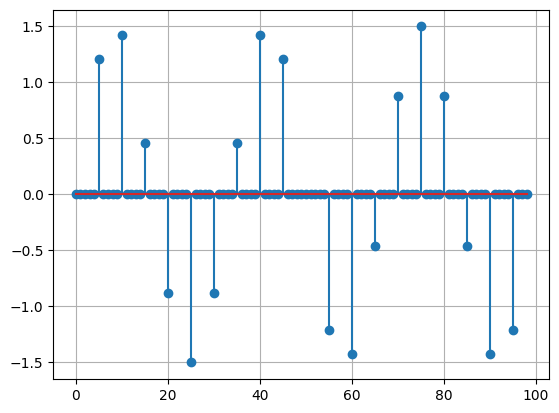

In [7]:
signalUp = dsp.upsample(sigDecimate, sigDecimate.size, 5)
signalUp = c2py(signalUp, sigDecimate.size*discard)

plt.stem(signalUp)
plt.grid();

### Teste MainUP

In [8]:
M = 4
SpS = 16
Rs = 100e6         # Taxa de símbolos [símbolo/s]
Ts = 1/Rs          # Período de símbolo em segundos
Fa = 1/(Ts/SpS)    # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa          # Período de amostragem

# define o comprimento do bitstream
Nbits = int(1e3*np.log2(M))

symbolsUp = dsp.mainUpSymbols(Nbits, SpS)
symbolsUp = c2py(symbolsUp, int((Nbits/2)*SpS))

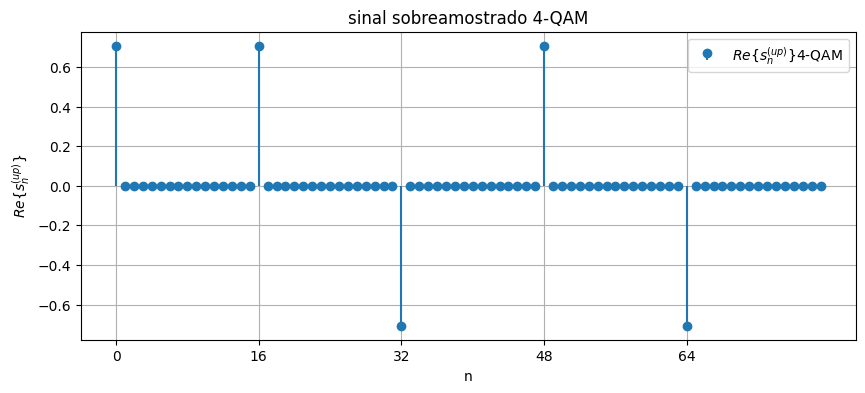

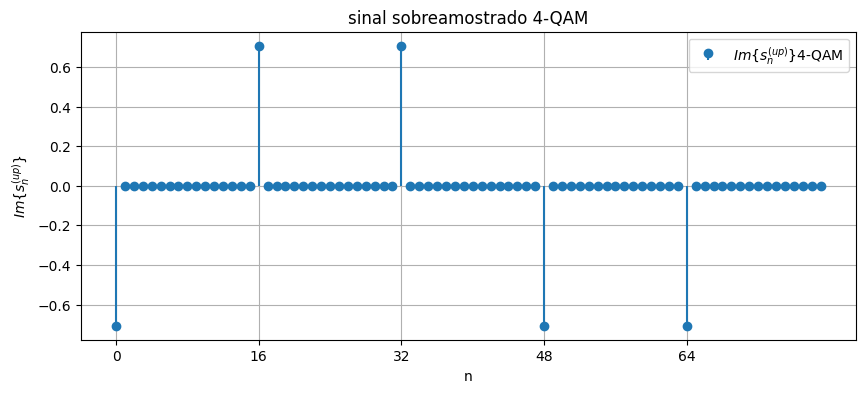

In [9]:
plt.figure(1, figsize=(10, 4))
plt.stem(symbolsUp[0:5*SpS].real, basefmt=" ", label ='$Re\{s_n^{(up)}\}$'+str(M)+'-QAM')
plt.xlabel('n')
plt.ylabel('$Re\{s_n^{(up)}\}$')
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 5*SpS, SpS))
plt.title('sinal sobreamostrado '+str(M)+'-QAM')
plt.grid();

plt.figure(2, figsize=(10, 4))
plt.stem(symbolsUp[0:5*SpS].imag, basefmt=" ", label ='$Im\{s_n^{(up)}\}$'+str(M)+'-QAM')
plt.xlabel('n')
plt.ylabel('$Im\{s_n^{(up)}\}$')
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 5*SpS, SpS))
plt.title('sinal sobreamostrado '+str(M)+'-QAM')
plt.grid();

### Teste para o filtro FIR

/home/silas/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/silas/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


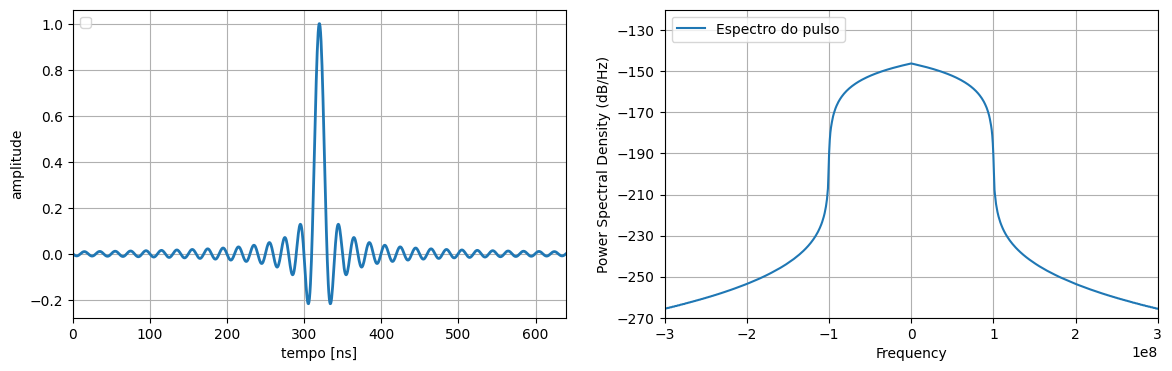

In [10]:
# pulso NRZ típico
pulse = pulseShape('rc', SpS, N=1024, alpha=0.01)
pulse = np.array(pulse/max(abs(pulse)), dtype=np.complex64)

t = np.arange(pulse.size)*(Ta/1e-9)

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].plot(t, pulse, '-', linewidth=2)
axs[0].set_xlabel('tempo [ns]')
axs[0].set_ylabel('amplitude')
axs[0].set_xlim(min(t), max(t))
axs[0].legend(loc='upper left');
axs[0].grid(True)

# plot psd
axs[1].set_xlim(-3*Rs, 3*Rs)
axs[1].set_ylim(-270, -120)
axs[1].psd(np.abs(pulse)**2, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do pulso')
axs[1].legend(loc='upper left');

In [11]:
sigTx = dsp.firFilter(symbolsUp, pulse, symbolsUp.size, pulse.size)
sigTx = c2py(sigTx, symbolsUp.size)

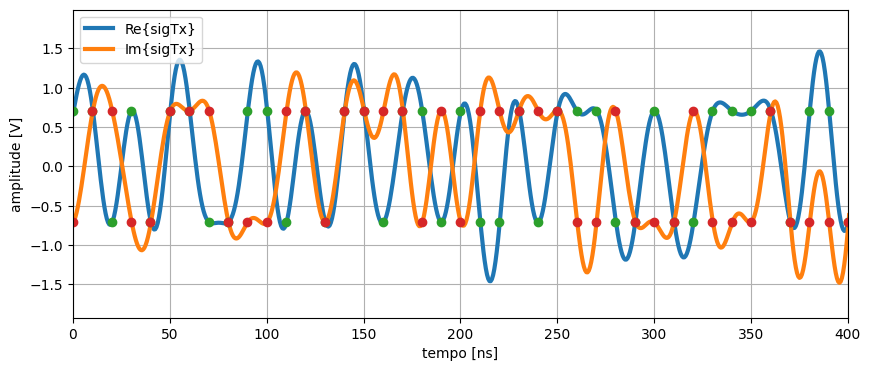

In [12]:
t = np.arange(0, sigTx.size)*(Ta)/1e-9

# instantes centrais de sinalização.
symbolsUp[symbolsUp==0+1j*0] = np.nan + 1j*np.nan

plt.figure(1, figsize=(10, 4))
plt.plot(t, sigTx.real, '-', linewidth=3, label='Re{sigTx}')
plt.plot(t, sigTx.imag, '-', linewidth=3, label='Im{sigTx}')
plt.plot(t, symbolsUp.real, 'o') 
plt.plot(t, symbolsUp.imag, 'o') 
plt.xlim(min(t), 400)
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude [V]')
plt.legend(loc='upper left')
plt.grid(True)

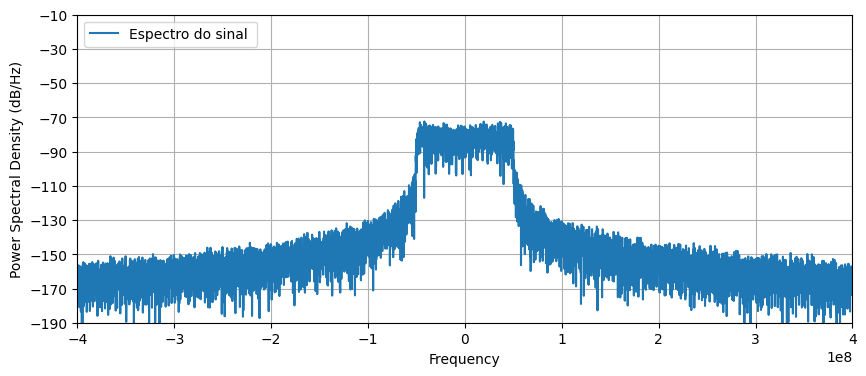

In [13]:
# plot psd
plt.figure(figsize=(10, 4))
plt.xlim(-4*Rs, 4*Rs)
plt.ylim(-190, -10)
plt.psd(sigTx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal ')
plt.legend(loc='upper left');

### Filtro Casado

In [14]:
# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.025  # variância
μ   = 0      # média

σ      = np.sqrt(σ2*SpS) 
ruido  = 1/np.sqrt(2)*(np.random.normal(μ, σ, Namostras) + 1j*np.random.normal(μ, σ, Namostras))

sigCh = np.array(sigTx + ruido, dtype=np.complex64)

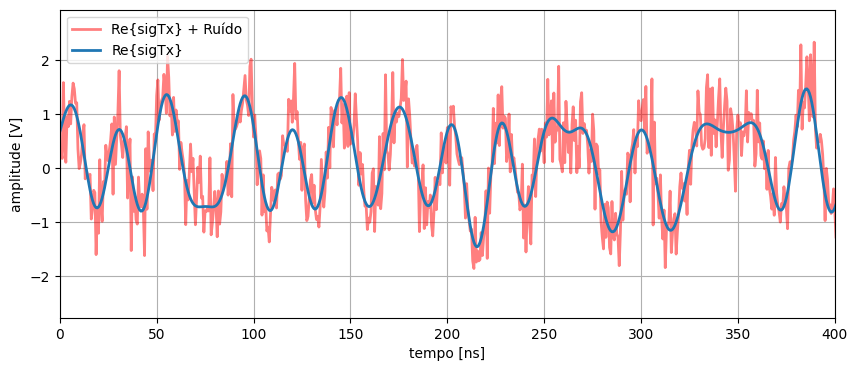

In [15]:
t = np.arange(0, sigTx.size)*(Ta)/1e-9

plt.figure(None, figsize=(10, 4))
plt.plot(t, sigTx.real + ruido, '-', linewidth=2, alpha=0.5, label='Re{sigTx} + Ruído', color='r')
plt.plot(t, sigTx.real, '-', linewidth=2, label='Re{sigTx}')
plt.xlim(min(t), 400)
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude [V]')
plt.legend(loc='upper left')
plt.grid(True);

In [16]:
sigRx = dsp.matchedFilter(sigCh, pulse, sigCh.size, pulse.size)
sigRx = np.ctypeslib.as_array(sigRx, shape=(sigCh.size,))
sigRx = tuple2numpy(sigRx)

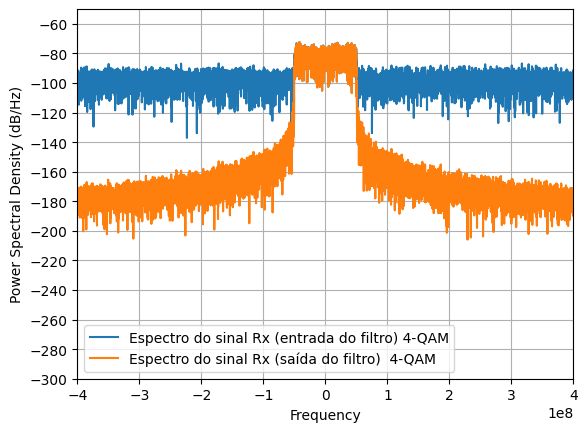

In [17]:
# plot PSD
plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-300,-50);
plt.psd(sigTx+ruido,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (entrada do filtro) '+ str(M) +'-QAM')
plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (saída do filtro)  '+ str(M) +'-QAM')
plt.legend(loc='lower left');

### Testa formatação de pulso

##### OptiCommPy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


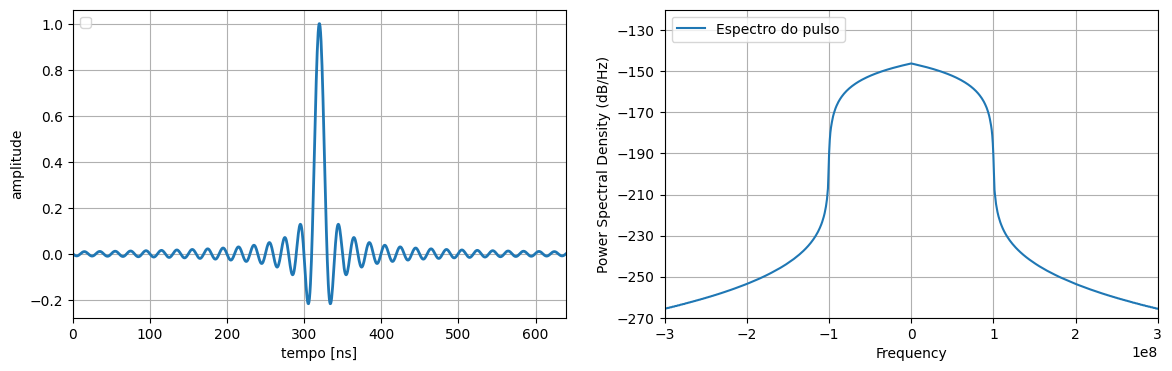

In [36]:
# pulso NRZ típico
pulse = pulseShape('rc', SpS, N=1024, alpha=0.01)
pulse = np.array(pulse/max(abs(pulse)), dtype=np.complex64)

t = np.arange(pulse.size)*(Ta/1e-9)

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].plot(t, pulse, '-', linewidth=2)
axs[0].set_xlabel('tempo [ns]')
axs[0].set_ylabel('amplitude')
axs[0].set_xlim(min(t), max(t))
axs[0].legend(loc='upper left');
axs[0].grid(True)

# plot psd
axs[1].set_xlim(-3*Rs, 3*Rs)
axs[1].set_ylim(-270, -120)
axs[1].psd(np.abs(pulse)**2, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do pulso')
axs[1].legend(loc='upper left');

##### Implementação em C

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


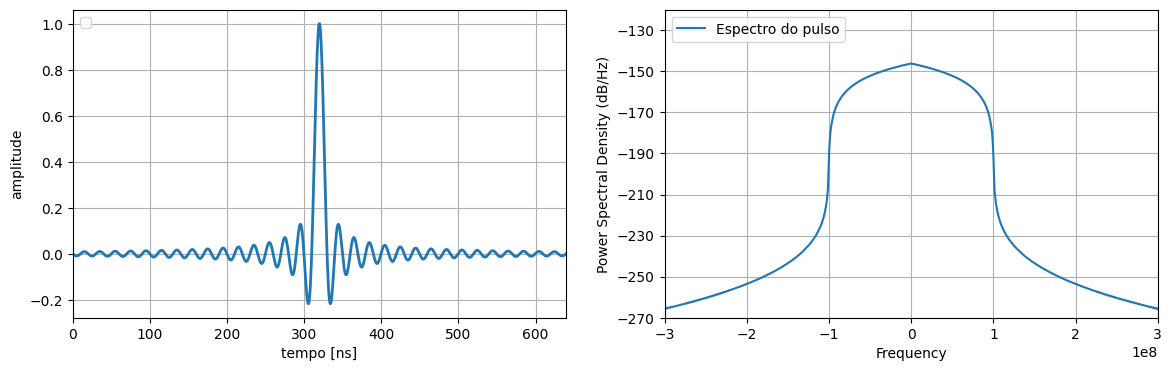

In [37]:
pulse = dsp.pulseShape(SpS, 1024, 0.01, 1)
pulse = c2py(pulse, 1024)

t = np.arange(pulse.size)*(Ta/1e-9)

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].plot(t, pulse, '-', linewidth=2)
axs[0].set_xlabel('tempo [ns]')
axs[0].set_ylabel('amplitude')
axs[0].set_xlim(min(t), max(t))
axs[0].legend(loc='upper left');
axs[0].grid(True)

# plot psd
axs[1].set_xlim(-3*Rs, 3*Rs)
axs[1].set_ylim(-270, -120)
axs[1].psd(np.abs(pulse)**2, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do pulso')
axs[1].legend(loc='upper left');